In [28]:
import pandas as pd
import numpy as np
from rdkit import Chem
import torch
import matplotlib.pyplot as plt
from deepdock.DockingFunction import get_torsions, GetDihedral
%matplotlib inline

In [3]:
results_df = torch.load('DockingResults_TestSet.chk')
results_df = pd.DataFrame.from_dict(results_df)
results_df.head()

,x,fun,nfev,nit,message,success,num_MixOfGauss,rmsd,pdb_id,score_real_mol,pkx,num_atoms,num_rotbonds,rotbonds
0,"[0.4068741664658634, -3.111903377819833, 2.669...",[-61.60544253382419],81378,500,Maximum number of iterations has been exceeded.,False,428,2.892180,3zsq,85.058905,4.96,39,14,"[(2, 10, 20, 31), (14, 11, 21, 33), (5, 12, 30..."
1,"[-2.0860038481249803, 0.36174218280227977, -0....",-204.159,8093,51,Optimization terminated successfully.,True,273,2.222657,6g34,192.097119,8.24,20,2,"[(3, 2, 1, 0), (6, 5, 4, 3)]"
2,"[1.1728373648793995, 1.711938601173987, 2.2464...",[-104.11306138437084],21802,134,Optimization terminated successfully.,True,469,1.667209,5w99,97.692953,4.68,34,7,"[(18, 1, 0, 15), (27, 26, 2, 18), (5, 4, 6, 24..."
3,"[0.6677677050421503, -1.6613927144064407, -0.6...",[-4.350164062386345],33354,212,Optimization terminated successfully.,True,117,0.569976,2q7q,1.262541,5.30,9,1,"[(3, 2, 1, 0)]"
4,"[-1.1667280590125937, 0.0006917577322102169, -...",[-100.44115467231256],33998,212,Optimization terminated successfully.,True,315,2.894431,2pbw,95.071165,8.25,22,7,"[(0, 1, 3, 4), (1, 3, 5, 6), (5, 6, 7, 8), (11..."


In [4]:
angles = []
tor_name = []
for i in range(len(results_df)):
    pdb_id = results_df.pdb_id[i]
    rmsd = results_df.rmsd[i]
    real_mol = Chem.MolFromMol2File('../../DeepDock/data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2',
                                    sanitize=False, cleanupSubstructures=False, removeHs=False)
    torsion = get_torsions([real_mol])
    
    if len(torsion)+6 != len(results_df.x[i]):
        print(i, pdb_id)
        continue
    

    for j in range(len(torsion)):
        l = [real_mol.GetAtoms()[a].GetSymbol() for a in torsion[j]]
        
        if '-'.join(l) not in tor_name:
            if  '-'.join(reversed(l)) not in tor_name:
                tor_name.append('-'.join(l))
            elif  '-'.join(reversed(l)) in tor_name:
                l = reversed(l)
        l = '-'.join(l)
    
        angles.append([pdb_id, rmsd, torsion[j], l, results_df.x[i][j+6], GetDihedral(real_mol.GetConformers()[0], torsion[j])])
        
angles = pd.DataFrame(angles, columns= ['pdb_id', 'rmsd', 'torsion', 'atom_types', 'predicted_angle', 'real_angle'])
angles.head()

RDKit WARNING: [18:29:46] 1w70_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [18:29:56] 4lil_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


,pdb_id,rmsd,torsion,atom_types,predicted_angle,real_angle
0,3zsq,2.89218,"(2, 10, 20, 31)",C-C-C-N,0.506878,0.799265
1,3zsq,2.89218,"(14, 11, 21, 33)",C-C-C-O,1.099219,-2.504558
2,3zsq,2.89218,"(5, 12, 30, 29)",C-C-C-C,-1.090216,-2.032617
3,3zsq,2.89218,"(3, 13, 25, 32)",C-C-C-N,-0.661869,-1.410737
4,3zsq,2.89218,"(4, 14, 26, 32)",C-C-C-N,3.086249,1.935763


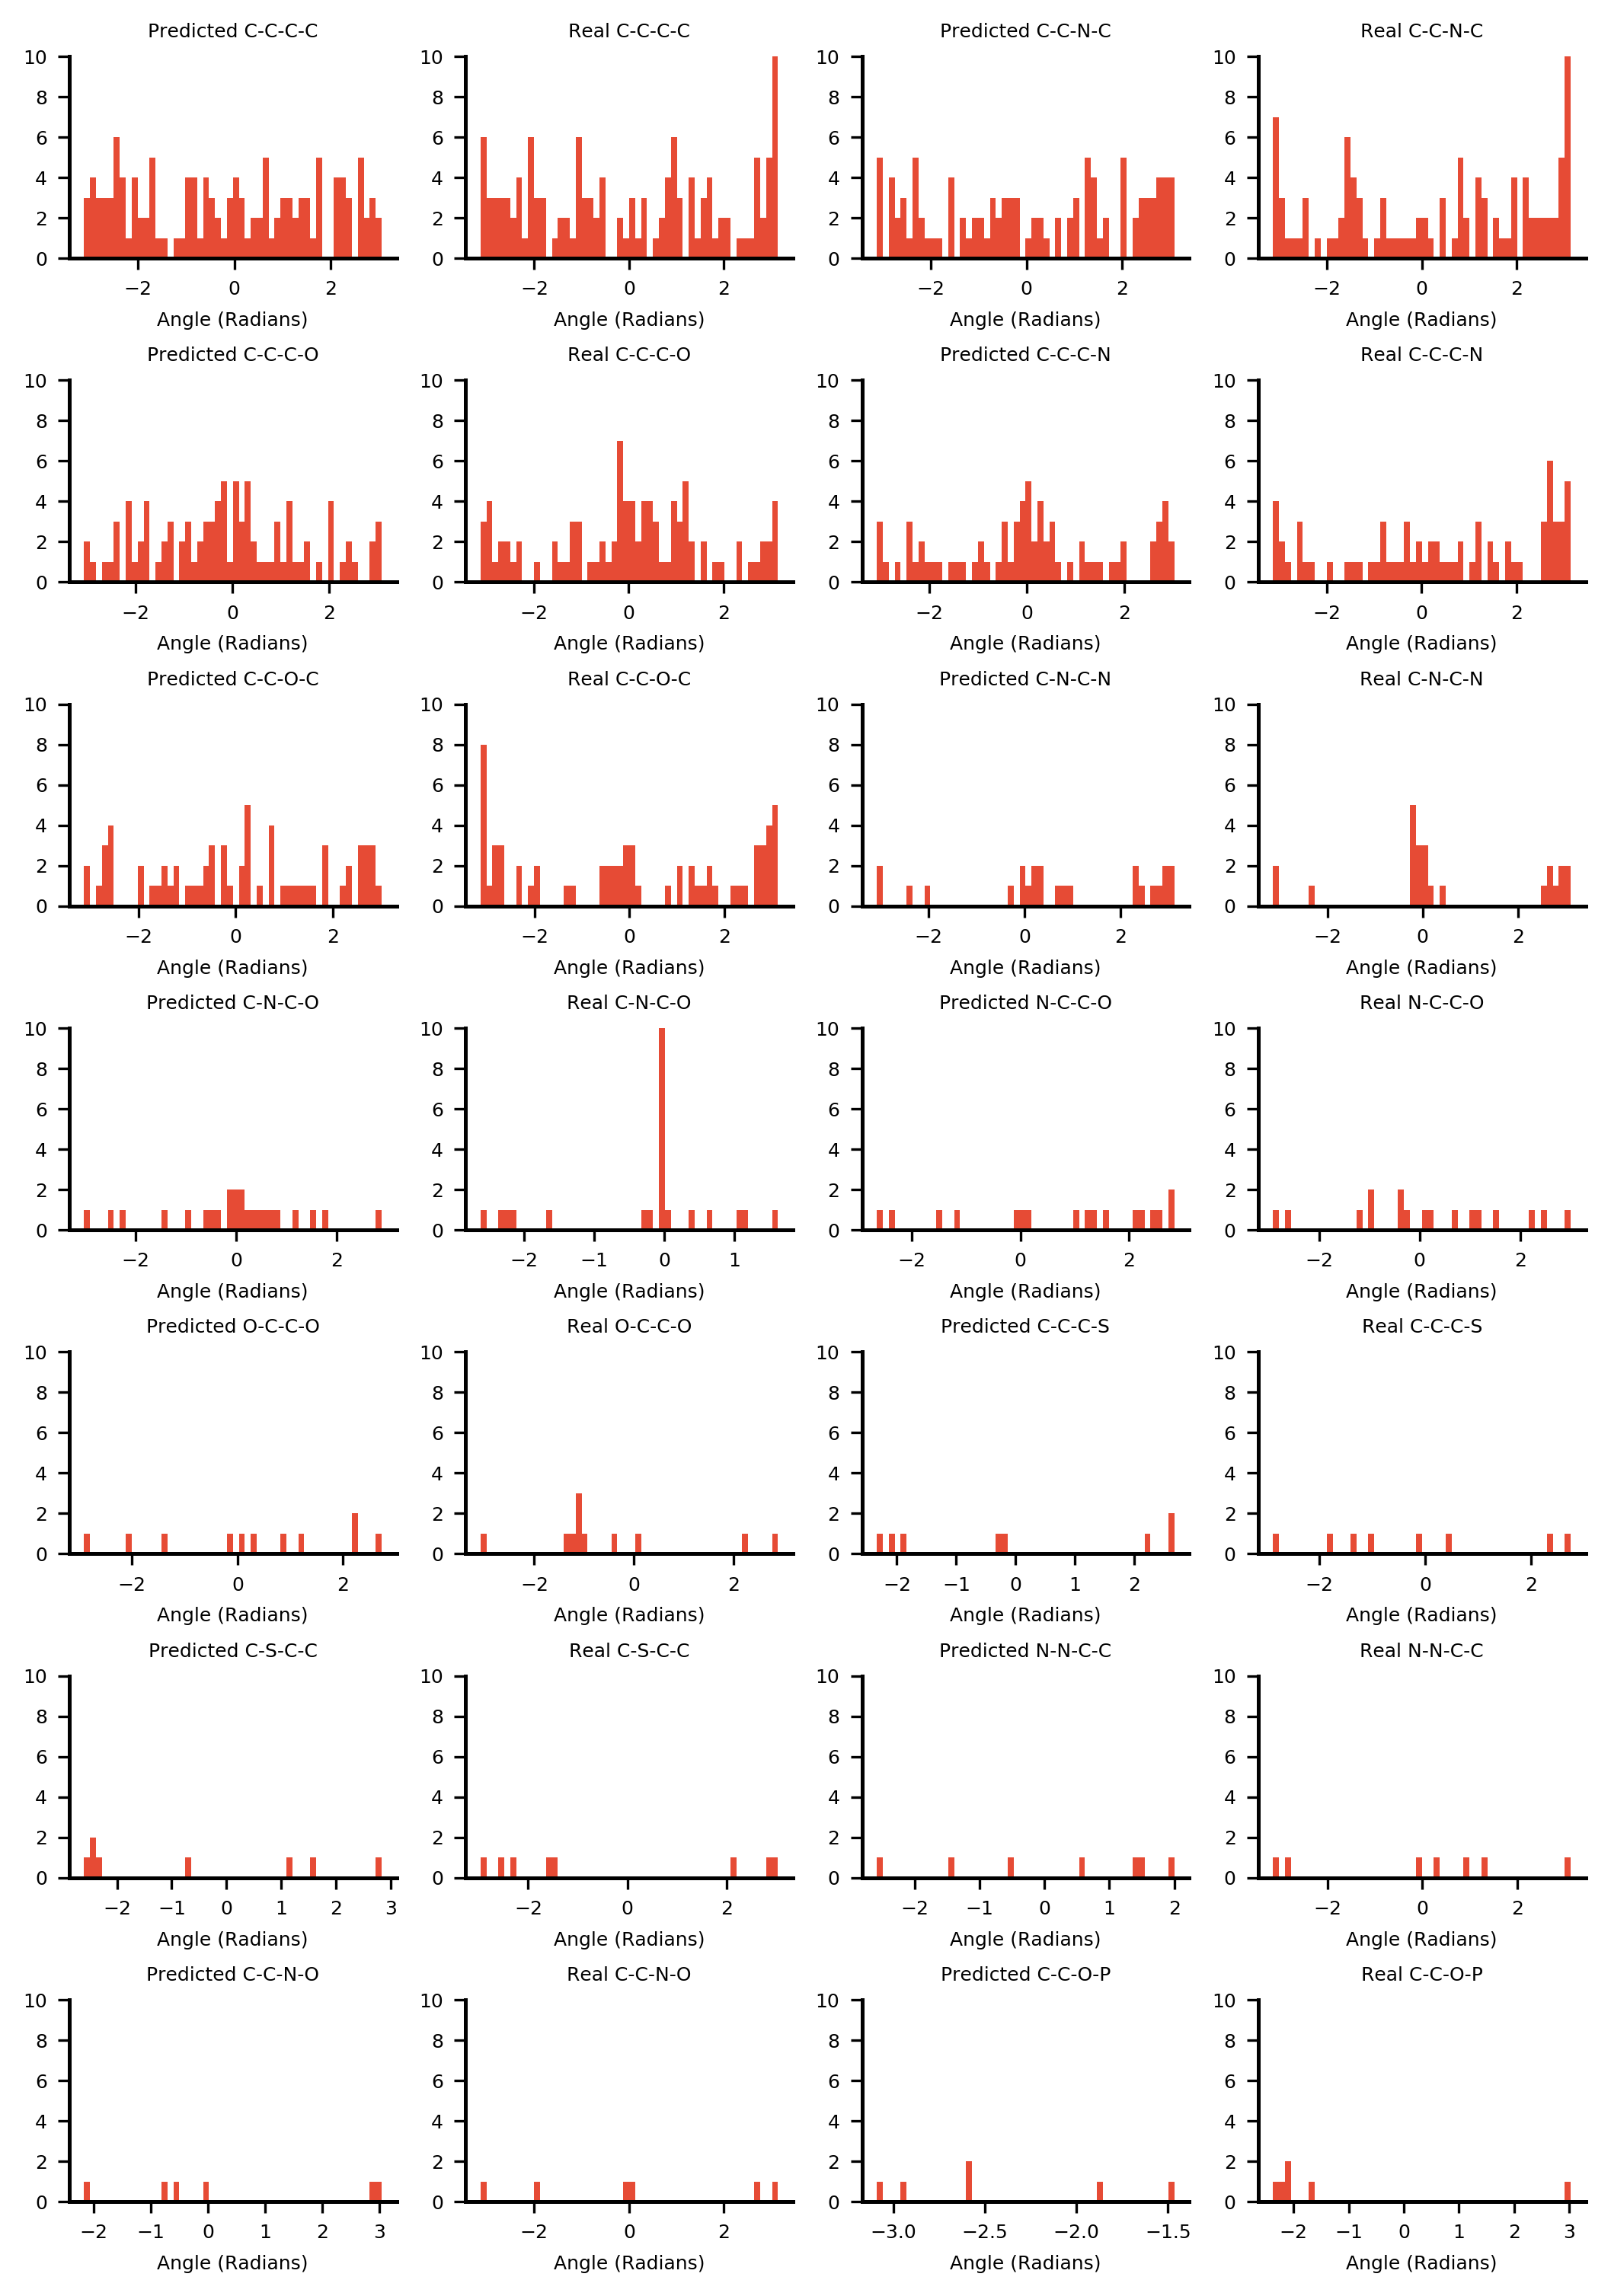

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams.update({'font.size': 5})
    
tor_names = angles[angles.rmsd <= 1].atom_types.value_counts().index.values
    
style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    matplotlib.rcParams.update({'xtick.labelsize': 6, 'ytick.labelsize': 6, 'font.size': 5,
                                'axes.titlesize': 6, 'axes.labelsize': 6})
    
    fig, ax = plt.subplots(7,4, figsize=(7, 10), dpi=300)

k = 0    
for i in range(len(ax)):
    for j in [0,2]:
        ax[i, j].hist(angles[(angles.atom_types==tor_names[k]) & (angles.rmsd <= 1) ].predicted_angle, bins=50)
        ax[i, j].set_xlabel('Angle (Radians)')
        ax[i, j].set_title('Predicted ' + tor_names[k])
        ax[i, j].axis(ymax=10)
        
        ax[i, j+1].hist(angles[(angles.atom_types==tor_names[k]) & (angles.rmsd <= 1) ].real_angle, bins=50)
        ax[i, j+1].set_xlabel('Angle (Radians)')
        ax[i, j+1].set_title('Real ' + tor_names[k])
        ax[i, j+1].axis(ymax=10)
        
        k += 1
plt.tight_layout()

/app/conda/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


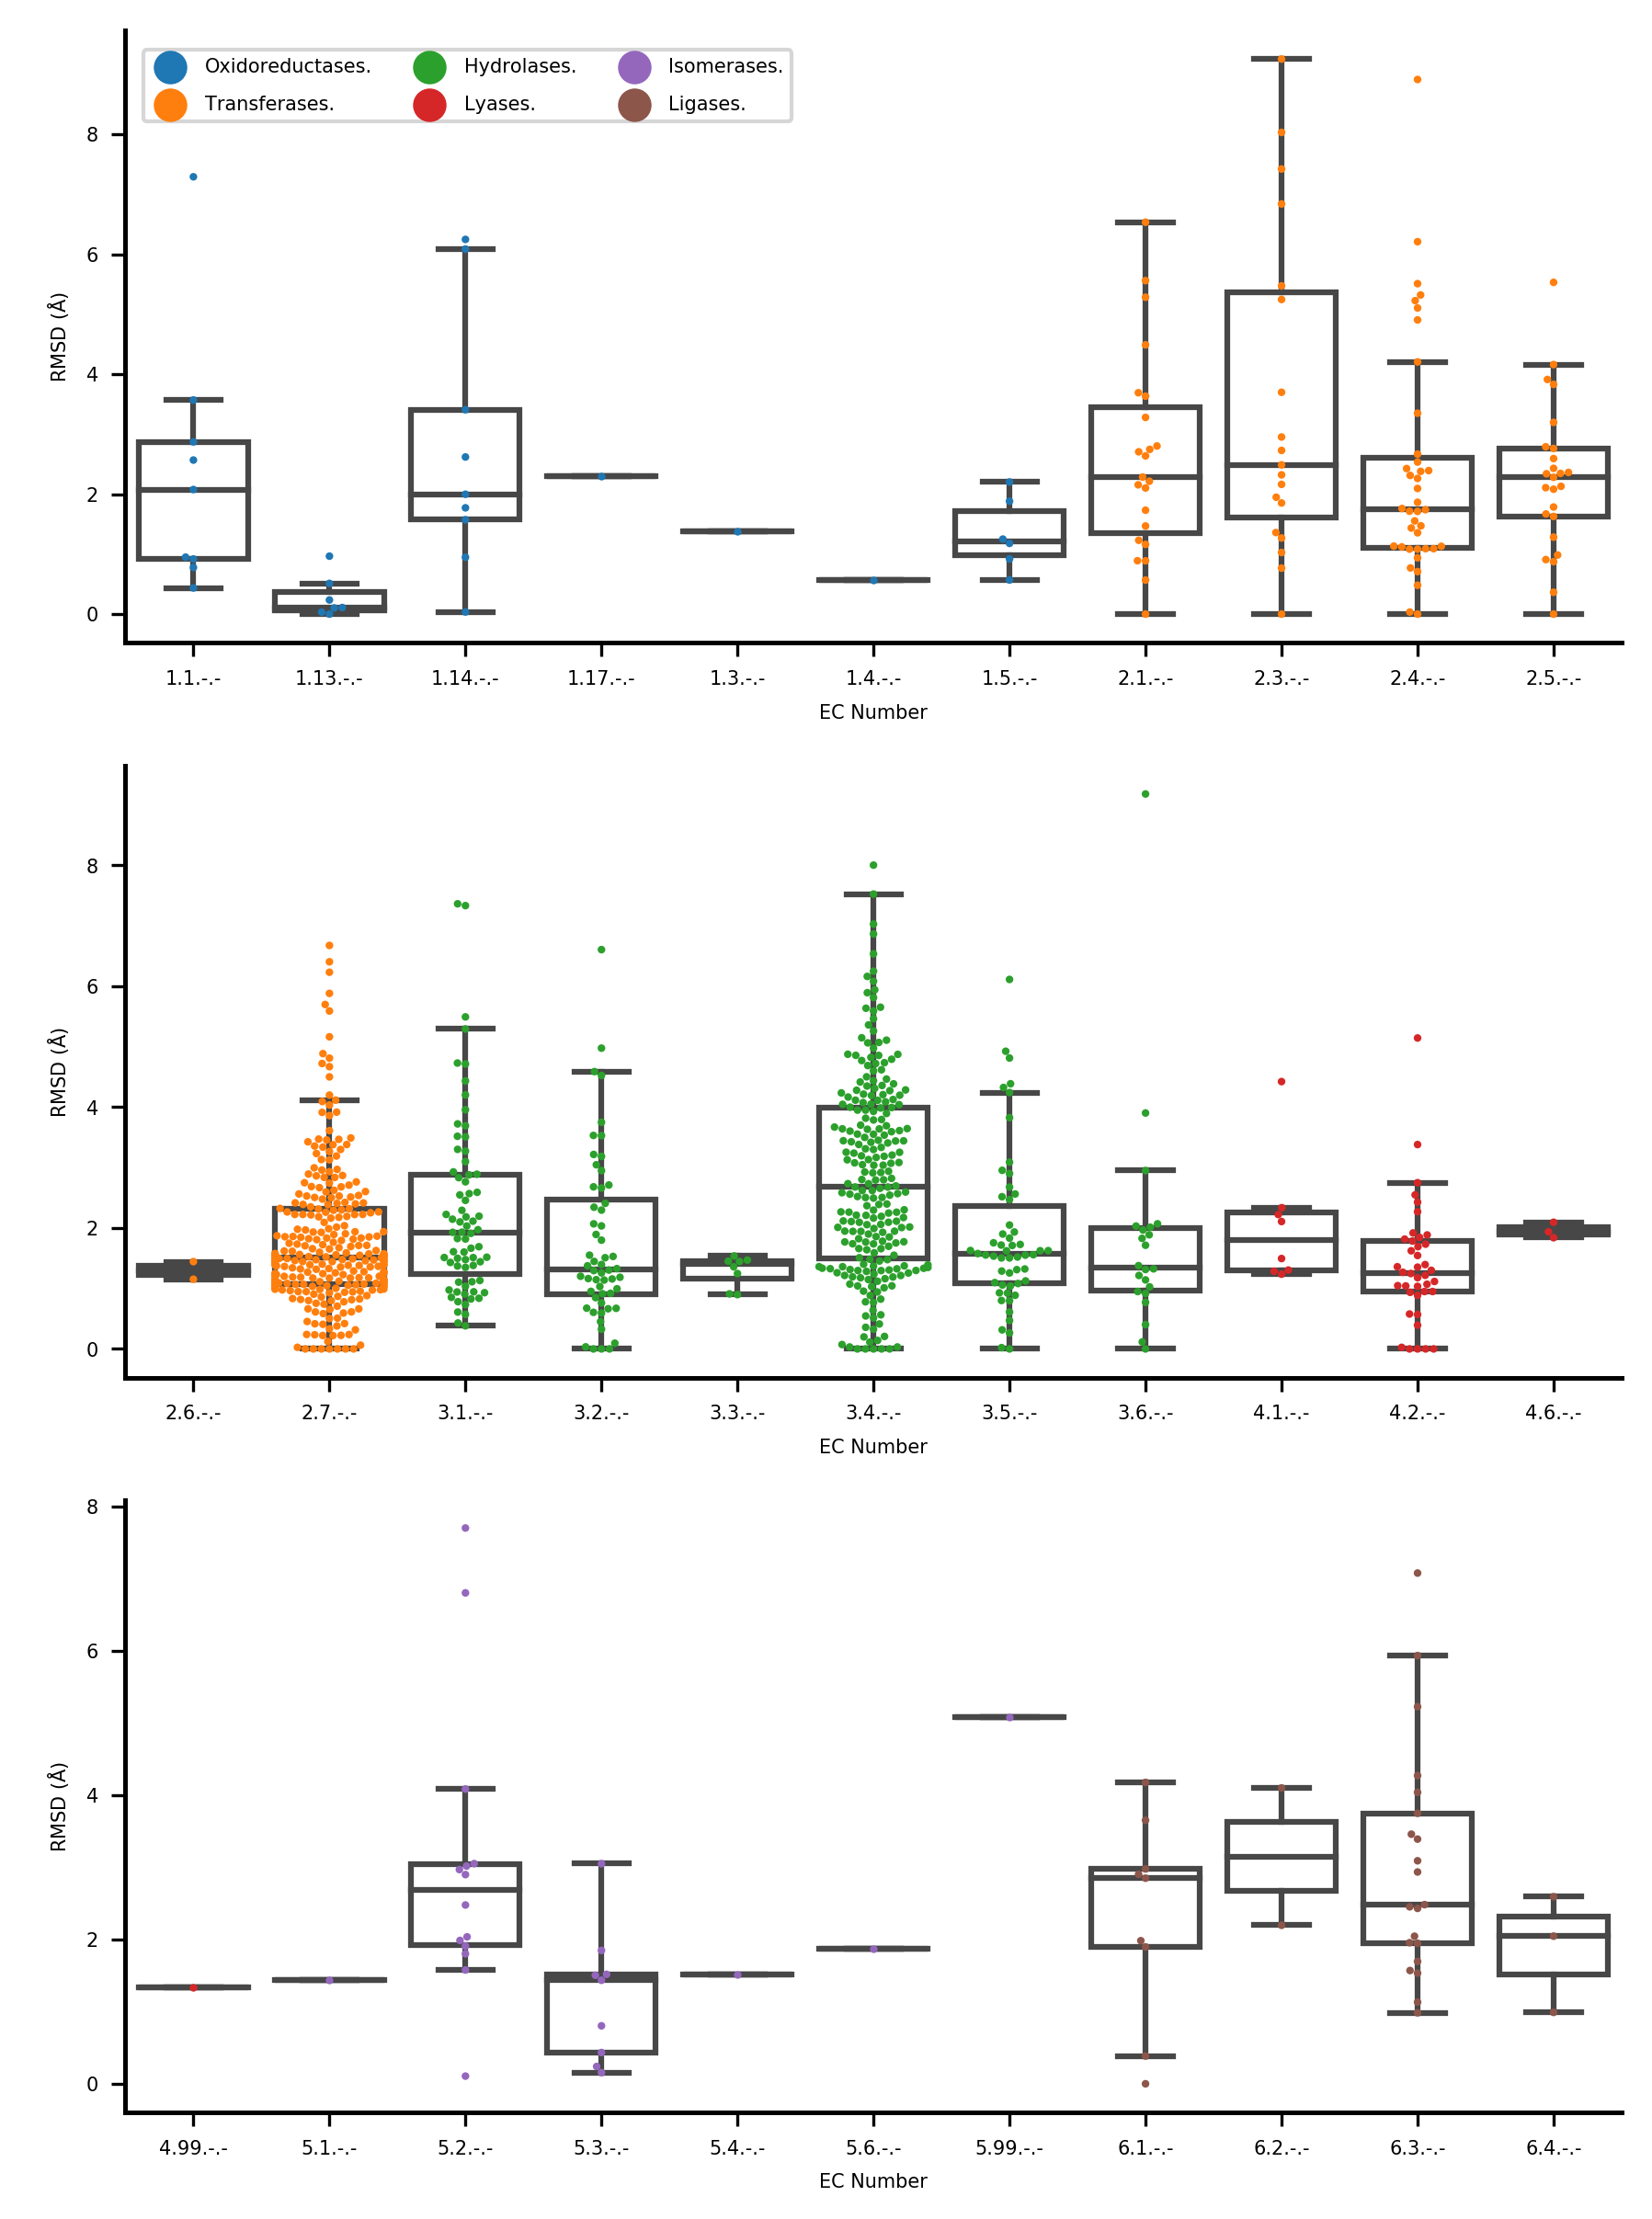

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('test_set_ECnumber.csv')
df = df.sort_values(by=['EC_Number1', 'EC_Number2', 'EC_Number3'])
df = df[~df.EC_Number2.isna()]
df['EC Number'] = df.EC_Number.apply(lambda x: '.'.join(str(x).split('.')[:2]+['-', '-']))
df = df.sort_values(by=['EC Number'])
names = [name for name in df['EC Number'].unique() if name is not np.nan]
pal = sns.color_palette()


style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    fig, ax = plt.subplots(3,1, figsize=(7, 10), dpi=300)
    
sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[:11])], ax=ax[0], size=2, palette=pal[:2])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[:11])], ax=ax[0],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[0].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[0].get_legend().remove()

sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[11:22])], ax=ax[1], size=2, palette=pal[1:4])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[11:22])], ax=ax[1],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[1].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[1].get_legend().remove()

sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[22:])], ax=ax[2], size=2, palette=pal[3:])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[22:])], ax=ax[2],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[2].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[2].get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lin = []
lab = []
for i in range(len(labels)):
    if labels[i] not in lab:
        lab.append(labels[i])
        lin.append(lines[i])
fig.legend(lin, lab, ncol=3, loc='upper right', bbox_to_anchor=(0.415,0.79), fontsize=5, labelspacing=1)

plt.show()

/app/conda/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


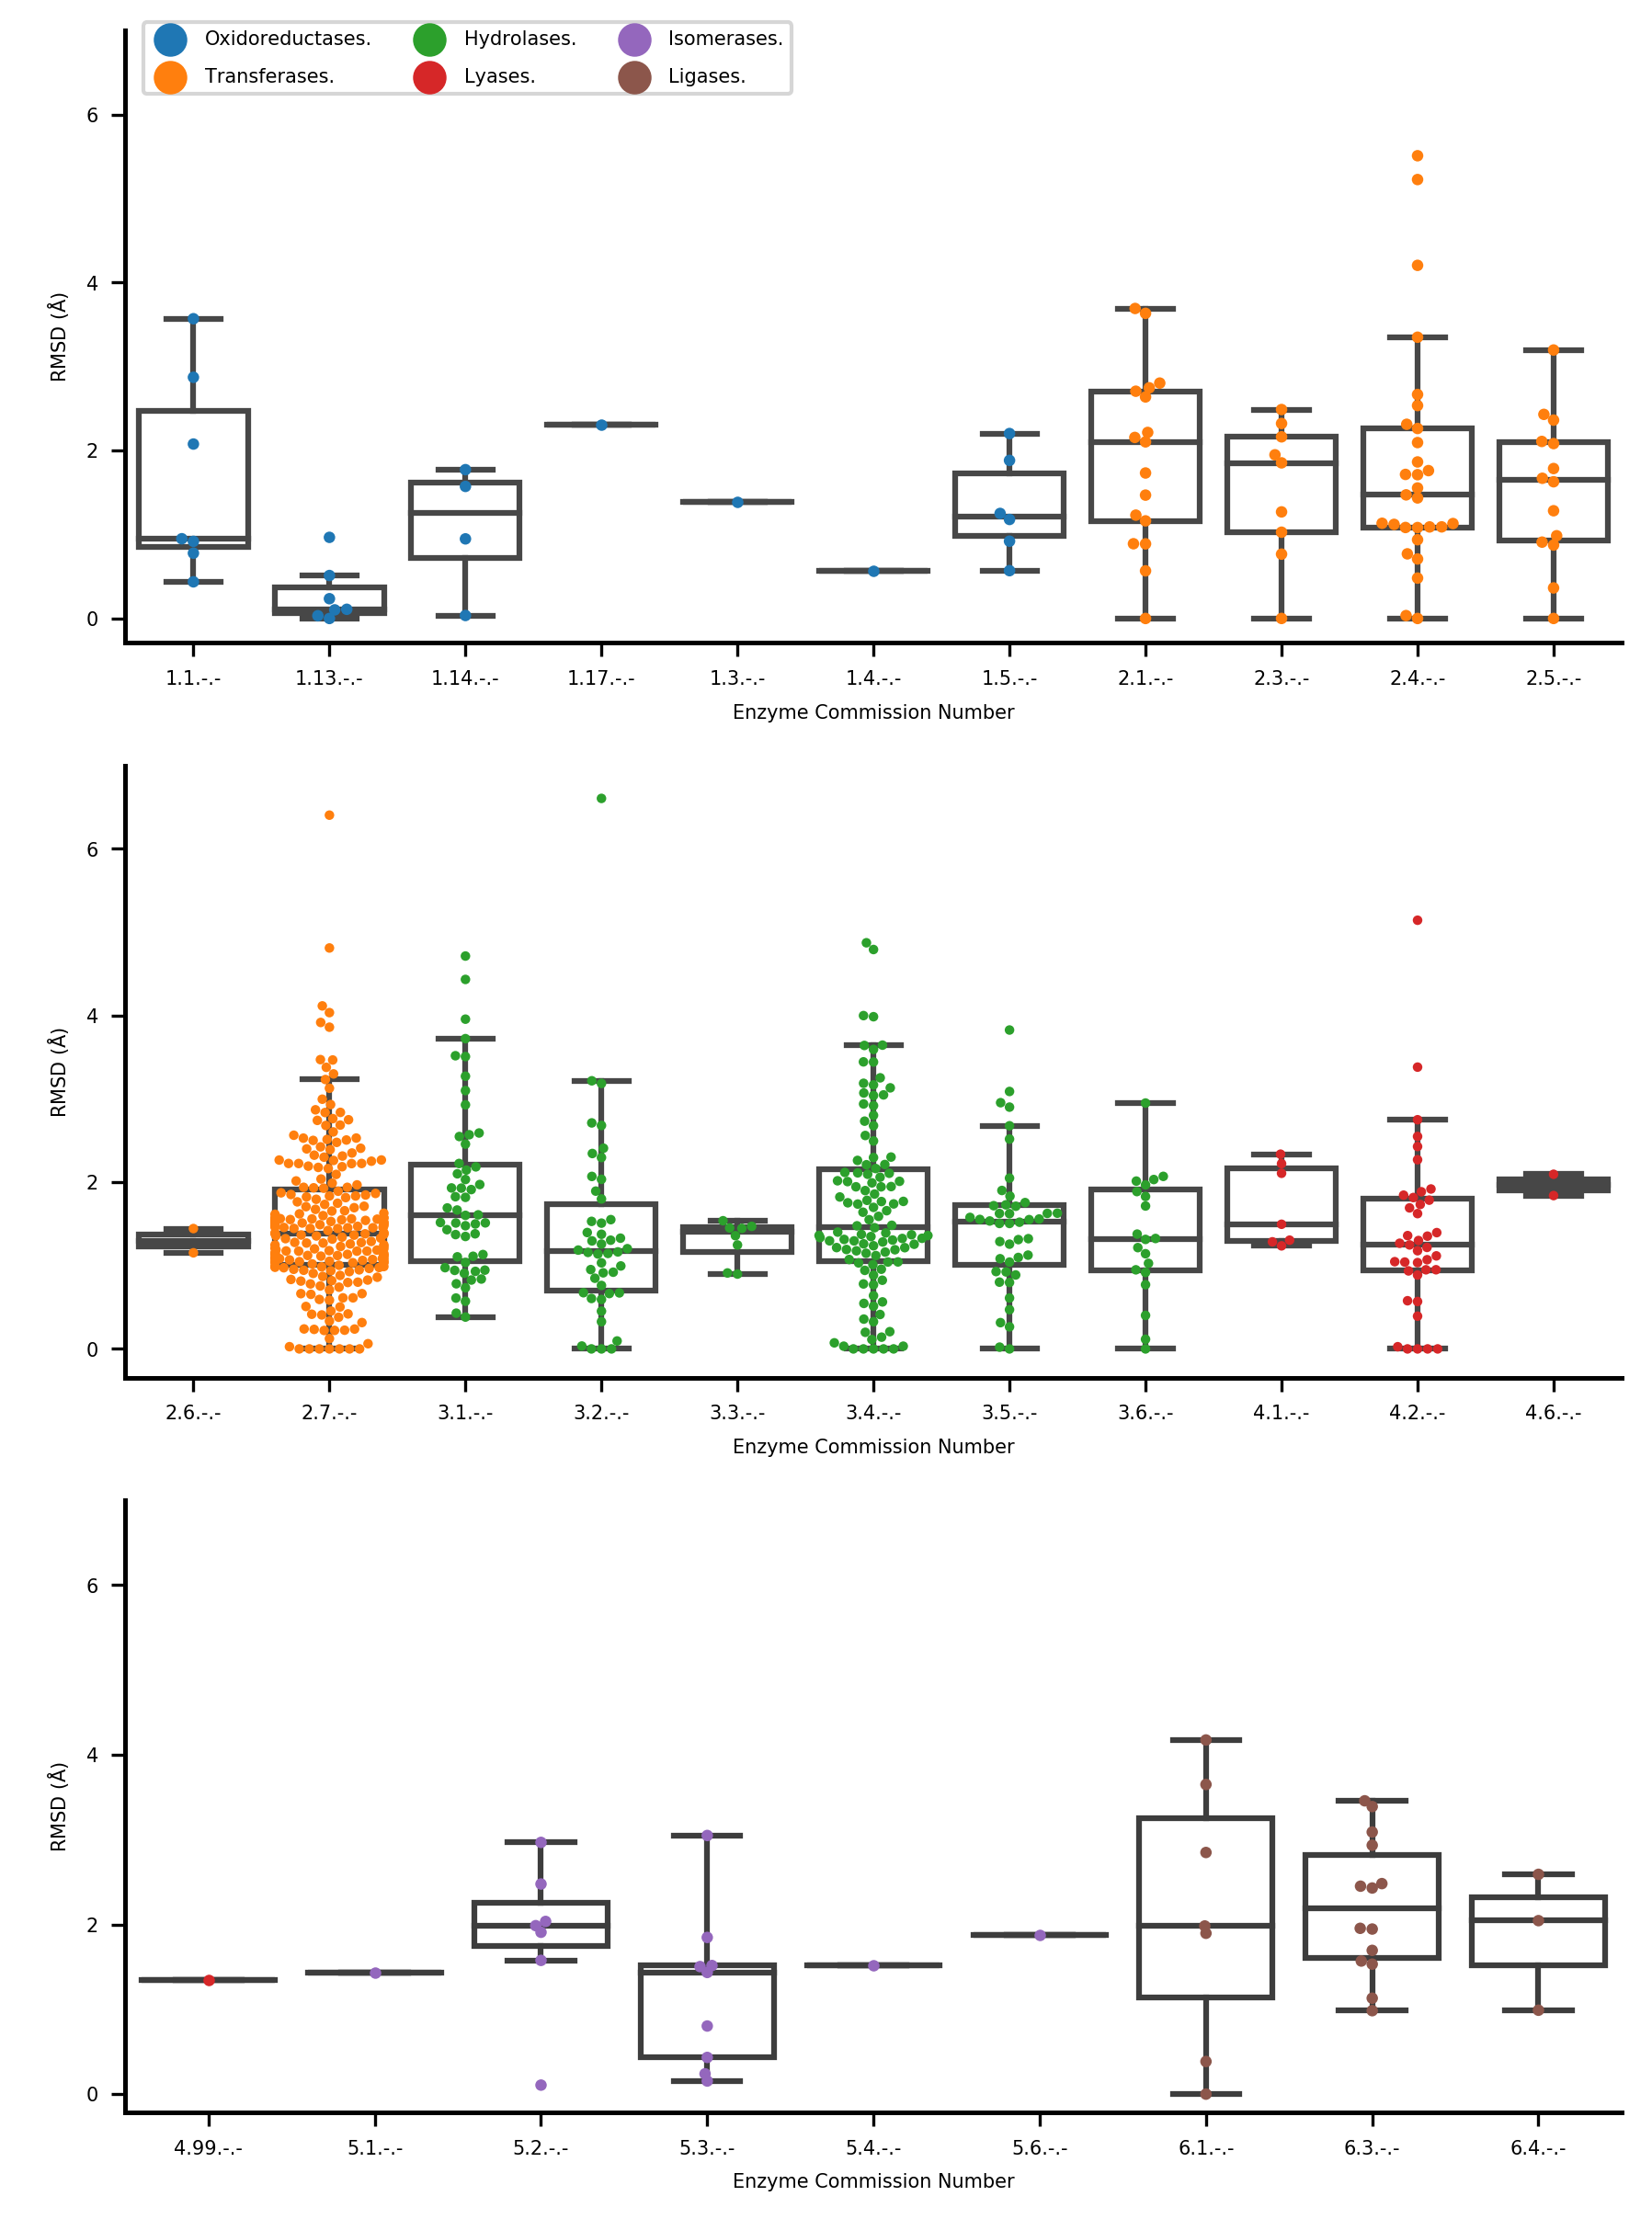

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('test_set_ECnumber.csv')
df = df[df.success]
df = df.sort_values(by=['EC_Number1', 'EC_Number2', 'EC_Number3'])
df = df[~df.EC_Number2.isna()]
df['EC Number'] = df.EC_Number.apply(lambda x: '.'.join(str(x).split('.')[:2]+['-', '-']))
df = df.sort_values(by=['EC Number'])
names = [name for name in df['EC Number'].unique() if name is not np.nan]
pal = sns.color_palette()


style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    fig, ax = plt.subplots(3,1, figsize=(7, 10), dpi=300)
    
sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[:11])], ax=ax[0], size=3, palette=pal[:2])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[:11])], ax=ax[0],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[0].set_xlabel('Enzyme Commission Number')
ax[0].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[0].get_legend().remove()
ax[0].axis(ymax=7)

sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[11:22])], ax=ax[1], size=2.5, palette=pal[1:4])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[11:22])], ax=ax[1],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[1].set_xlabel('Enzyme Commission Number')
ax[1].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[1].get_legend().remove()
ax[1].axis(ymax=7)

sns.swarmplot(x="EC Number", y="rmsd", hue="EC_Number1", data=df[df['EC Number'].isin(names[22:])], ax=ax[2], size=3, palette=pal[3:])
sns.boxplot(x="EC Number", y="rmsd", data=df[df['EC Number'].isin(names[22:])], ax=ax[2],
        boxprops={'facecolor':'None'}, showfliers=False)# showcaps=True, whiskerprops={'linewidth':1},
ax[2].set_xlabel('Enzyme Commission Number')
ax[2].set_ylabel('RMSD ($\mathrm{\AA}$)')
ax[2].get_legend().remove()
ax[2].axis(ymax=7)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lin = []
lab = []
for i in range(len(labels)):
    if labels[i] not in lab:
        lab.append(labels[i])
        lin.append(lines[i])
fig.legend(lin, lab, ncol=3, loc='upper right', bbox_to_anchor=(0.415,0.8), fontsize=5, labelspacing=1)

plt.show()